# Playground Series - Season 4, Episode 1 - Binary Classification with a Bank Churn Dataset

In [1]:
#basics
import numpy as np
import pandas as pd
import seaborn as sns
import time
import matplotlib.pyplot as plt
import missingno as msno

import warnings
warnings.filterwarnings("ignore")
display = pd.options.display
display.max_columns = None

#preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import QuantileTransformer, quantile_transform

#statistics
from scipy import stats
from scipy.stats import skew
from scipy.special import boxcox1p


#feature engineering
from sklearn.feature_selection import mutual_info_classif


#transformers and pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import set_config


#algorithms
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


#model evaluation
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, log_loss, f1_score, fbeta_score, auc, balanced_accuracy_score
from sklearn.metrics import make_scorer, accuracy_score, RocCurveDisplay, confusion_matrix, recall_score

# Optuna and visualization tools
import optuna
from optuna.samplers import TPESampler
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

# Dealing with imbalanced target
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline

#Stacking & ensembling
from sklearn.model_selection import GridSearchCV
from mlxtend.classifier import StackingCVClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier

random_state = 42

## READING FILES

**Bank Customer Churn Dataset**

The Bank Customer Churn Dataset is a commonly used dataset for predicting customer churn in the banking industry. It contains information on bank customers who either left the bank or continue to be customers. The dataset includes the following attributes:
- Customer ID: A unique identifier for each customer.
- Surname: The customer's surname or last name.
- Credit Score: A numerical value representing the customer's credit score.
- Geography: The country where the customer resides (France, Spain, or Germany).
- Gender: The customer's gender (Male or Female).
- Age: The customer's age.
- Tenure: The number of years the customer has been with the bank.
- Balance: The customer's account balance.
- NumOfProducts: The number of bank products the customer uses (e.g., savings account, credit card).
- HasCrCard: Whether the customer has a credit card (1 = yes, 0 = no).
- IsActiveMember: Whether the customer is an active member (1 = yes, 0 = no).
- EstimatedSalary: The estimated salary of the customer.
- Exited: Whether the customer has churned (1 = yes, 0 = no).

In [2]:
train_df = pd.read_csv('data/train.csv', index_col='id')
test_df = pd.read_csv('data/test.csv',index_col='id')
submission = pd.read_csv('data/sample_submission.csv')

## 1) EDA - Exploratory Data Analysis

In [3]:
train_df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
id,,,,,,,,,,,,,
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


### 1.1) data summary information

In [4]:
# create a summary table for the training data
summary_table = pd.DataFrame(train_df.dtypes, columns=['dtypes'])
summary_table['Missing'] = train_df.isnull().sum()
summary_table['Unique'] = train_df.nunique()
summary_table['Count'] = train_df.count()
summary_table['Duplicated'] = train_df.duplicated().sum()
summary_table['Skewness'] = train_df.skew()
summary_table['Kurtosis'] = train_df.kurt()
summary_table

,dtypes,Missing,Unique,Count,Duplicated,Skewness,Kurtosis
CustomerId,int64,0,23221,165034,0,-0.022940,-1.207421
Surname,object,0,2797,165034,0,NaN,NaN
CreditScore,int64,0,457,165034,0,-0.059291,-0.067452
Geography,object,0,3,165034,0,NaN,NaN
Gender,object,0,2,165034,0,NaN,NaN
Age,float64,0,71,165034,0,0.968063,1.532406
Tenure,int64,0,11,165034,0,0.006490,-1.157921
Balance,float64,0,30075,165034,0,0.382020,-1.600852
NumOfProducts,int64,0,4,165034,0,0.368278,-0.278059
HasCrCard,float64,0,2,165034,0,-1.179255,-0.609365


0    0.788401
1    0.211599
Name: Exited, dtype: float64


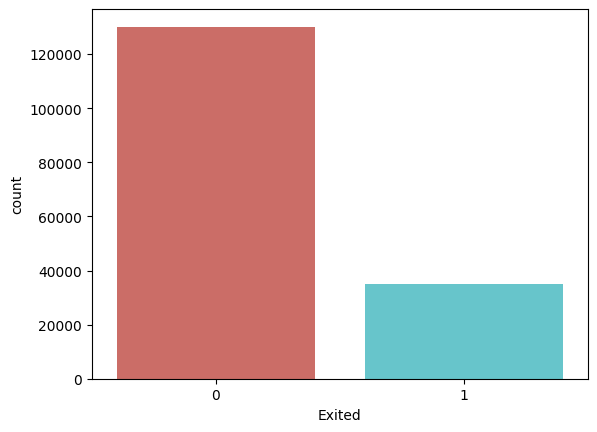

In [5]:
# let's look at the target variable
print(train_df['Exited'].value_counts(normalize=True))


# let's look at the distribution of the target variable
sns.countplot(x='Exited', data=train_df, palette='hls'); #imbalanced dataset

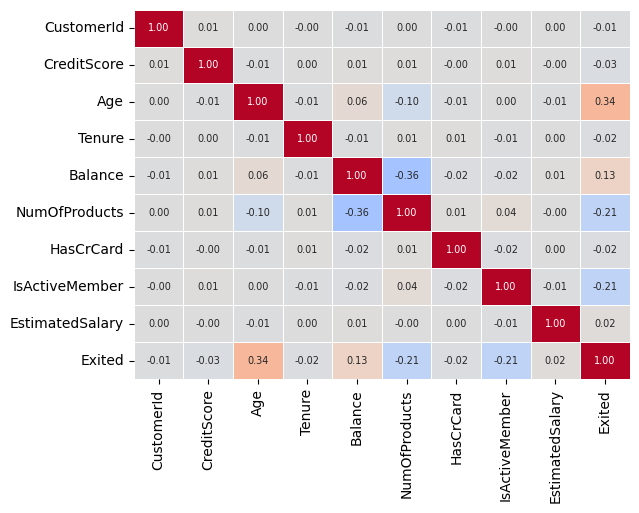

In [6]:
correlation_matrix = train_df.select_dtypes(exclude='object').corr()
column_names = correlation_matrix.columns
sns.heatmap(correlation_matrix.round(2),
            xticklabels=column_names,
            yticklabels=column_names,
            cmap="coolwarm",
            vmin=-1,
            vmax=1,
            annot=True,
            fmt=".2f",
            linewidths=0.5,
            annot_kws={"size": 7},
            cbar=False);


## 2) PreProcess Data

In [7]:
# class transformer that will help us to create the new features Surname_Length, Surname_Frequency and Surname_Ratio_Frequency_Length
class CreateSurnameFeatures(BaseEstimator, TransformerMixin):
    """This class helps to create new features based on the 'Surname' column."""
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        data = X.copy()
        data['Surname_Length'] = data['Surname'].apply(len)
        data['Surname_Frequency'] = data['Surname'].map(data['Surname'].value_counts())
        data['Surname_Ratio_Frequency_Length'] = data['Surname_Frequency'] / data['Surname_Length']
        return data

    def get_feature_names_out(self, input_features=None):
        return input_features + ['Surname_Length', 'Surname_Frequency', 'Surname_Ratio_Frequency_Length']

# this class will create a new feature based on balance to salary ratio
class BalanceSalaryRatio(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        data = X.copy()
        data['BalanceSalaryRatio'] = data['Balance'] / data['EstimatedSalary']
        return data

    def get_feature_names_out(self, input_features=None):
        return input_features + ['BalanceSalaryRatio']

# this class will create a new feature of num of products and has card interaction
class NumOfProductsHasCrCardInteraction(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        data = X.copy()
        data['NumOfProductsHasCrCardInteraction'] = data['NumOfProducts'] * data['HasCrCard']
        return data

    def get_feature_names_out(self, input_features=None):
        return input_features + ['NumOfProductsHasCrCardInteraction']

# this class will create a new feature based on the relation between balance and number of products
class BalanceNumOfProductsInteraction(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        data = X.copy()
        data['BalanceNumOfProductsInteraction'] = data['Balance'] * data['NumOfProducts']
        return data

    def get_feature_names_out(self, input_features=None):
        return input_features + ['BalanceNumOfProductsInteraction']

# this class will create a new feature based on age and number of products
class AgeNumOfProductsInteraction(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        data = X.copy()
        data['AgeNumOfProductsInteraction'] = data['Age'] * data['NumOfProducts']
        return data

    def get_feature_names_out(self, input_features=None):
        return input_features + ['AgeNumOfProductsInteraction']

# this class will create a new feature based on tenure and age ratio
class TenureAgeRatio(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        data = X.copy()
        data['TenureAgeRatio'] = data['Tenure'] / data['Age']
        return data

    def get_feature_names_out(self, input_features=None):
        return input_features + ['TenureAgeRatio']

# this class will create a new  feature based on based on tenure and is active member and class it LoyaltyScore
class LoyaltyScore(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        data = X.copy()
        data['LoyaltyScore'] = data['Tenure'] * data['IsActiveMember']
        return data

    def get_feature_names_out(self, input_features=None):
        return input_features + ['LoyaltyScore']

# this class will help us bin the age variable
class AgeBinner(BaseEstimator, TransformerMixin):
    def __init__(self, num_bins):
        self.num_bins = num_bins

    def fit(self, X, y=None):
        # Calculate bin edges dynamically based on data distribution
        _, bin_edges = pd.cut(X['Age'], bins=self.num_bins, retbins=True)
        self.bin_edges = bin_edges
        return self

    def transform(self, X):
        data = X.copy()
        bin_labels = [f'{int(self.bin_edges[i])}-{int(self.bin_edges[i+1])}' for i in range(len(self.bin_edges)-1)]
        data['Age_Bins'] = pd.cut(data['Age'], bins=self.bin_edges, labels=bin_labels, precision=0)
        data['Age_Bins'] = data['Age_Bins'].astype('object')
        return data

    def get_feature_names_out(self, input_features=None):
        return [col for col in input_features if col not in ['Age']]

# this class will help us bin credit score
class CreditScoreBinner(BaseEstimator, TransformerMixin):
    def __init__(self, num_bins):
        self.num_bins = num_bins

    def fit(self, X, y=None):
        # Calculate bin edges dynamically based on data distribution
        _, bin_edges = pd.cut(X['CreditScore'], bins=self.num_bins, retbins=True)
        self.bin_edges = bin_edges
        return self

    def transform(self, X):
        data = X.copy()
        bin_labels = [f'{int(self.bin_edges[i])}-{int(self.bin_edges[i+1])}' for i in range(len(self.bin_edges)-1)]
        data['CreditScore_Bins'] = pd.cut(data['CreditScore'], bins=self.bin_edges, labels=bin_labels, precision=0)
        data['CreditScore_Bins'] = data['CreditScore_Bins'].astype('object')
        return data

    def get_feature_names_out(self, input_features=None):
        return [col for col in input_features if col not in ['CreditScore']]

# class helps select columns categorical or numerical columns
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None, dtypes=None):
        self.columns = columns
        self.dtypes = dtypes

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        data = X.copy()
        if self.columns:
            data = data[self.columns]
        if self.dtypes:
            data = data.select_dtypes(include=self.dtypes)
        return data

    def get_feature_names_out(self, input_features=None):
        return [col for col in input_features if col in self.columns]

# this class will help us to drop unwanted columns
class DropUnwantedColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        data = X.copy()
        return data.drop(labels=self.columns, axis='columns')

    def get_feature_names_out(self, input_features=None):
        return [col for col in input_features if col not in self.columns]

# ----------------------------------

# feature engineering pipeline
feat_pipeline = Pipeline([
    ('surname_features', CreateSurnameFeatures()),
    ('balance_salary_ratio', BalanceSalaryRatio()),
    ('num_of_products_has_cr_card_interaction', NumOfProductsHasCrCardInteraction()),
    ('balance_num_of_products_interaction', BalanceNumOfProductsInteraction()),
    ('age_num_of_products_interaction', AgeNumOfProductsInteraction()),
    ('tenure_age_ratio', TenureAgeRatio()),
    ('loyalty_score', LoyaltyScore()),
    ('age_binner', AgeBinner(num_bins=10)),
    ('credit_score_binner', CreditScoreBinner(num_bins=10)),
])

# ----------------------------------
columns_to_drop = ['CustomerId', 'Surname', 'Age', 'CreditScore']

# identifying categorical and numerical features
cat_ohe_features = ['Age_Bins','CreditScore_Bins','Tenure','Geography','Gender','NumOfProducts']

num_features = ['EstimatedSalary', 'Surname_Length', 'Surname_Frequency', 'Surname_Ratio_Frequency_Length' \
    ,'BalanceSalaryRatio', 'NumOfProductsHasCrCardInteraction','TenureAgeRatio','LoyaltyScore','BalanceNumOfProductsInteraction'\
    ,'AgeNumOfProductsInteraction','Balance']

# ----------------------------------
# create a pipeline for numerical features
num_pipeline = Pipeline([
    ('num_selector', ColumnSelector(columns=num_features)),
    ('scaler', RobustScaler()),
])

# create a pipeline for categorical features
cat_pipeline = Pipeline([
    ('cat_selector', ColumnSelector(columns=cat_ohe_features)),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore')),
])

# create a full pipeline to preprocess the data
encode_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_ohe_features),
    ('pass', 'passthrough', ['HasCrCard','IsActiveMember'])
])

preprocessor = Pipeline([
    ('feat_pipeline', feat_pipeline),
    ('drop_columns', DropUnwantedColumns(columns=columns_to_drop)),
    ('encode_pipeline', encode_pipeline),
])


# fit data to the pipeline
X = preprocessor.fit_transform(train_df)
y = train_df['Exited']

In [8]:
X = pd.DataFrame(train_df)
y = pd.DataFrame(test_df)

X.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
id,,,,,,,,,,,,,
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [43]:
mutual_df_categorical = train_df[cat_ohe_features]
#categorical features must be encoded to get mutual information
for colname in mutual_df_categorical:
    mutual_df_categorical[colname], _ = mutual_df_categorical[colname].factorize()
mutual_info = mutual_info_classif(mutual_df_categorical, y, random_state=1)

mutual_info = pd.Series(mutual_info)
mutual_info.index = mutual_df_categorical.columns
pd.DataFrame(mutual_info.sort_values(ascending=False), columns = ["Categorical_Feature_MI"] ).style.background_gradient("cool")

,Categorical_Feature_MI
NumOfProducts,0.095667
Age_Bins,0.076851
Geography,0.025254
Gender,0.021492
CreditScore_Bins,0.005527
Tenure,0.001489


In [44]:
# determine the mutual information for numerical features
#You need to fill missing values to get results from mutual_info_classif function
mutual_df = train_df[num_features]

mutual_info = mutual_info_classif(mutual_df, y, random_state=42)

mutual_info = pd.Series(mutual_info)
mutual_info.index = mutual_df.columns
mutual_info = pd.DataFrame(mutual_info.sort_values(ascending=False), columns = ["Numerical_Feature_MI"] )
mutual_info.style.background_gradient("cool")

,Numerical_Feature_MI
AgeNumOfProductsInteraction,0.103928
NumOfProductsHasCrCardInteraction,0.082224
TenureAgeRatio,0.053159
BalanceNumOfProductsInteraction,0.028033
LoyaltyScore,0.023996
Balance,0.015335
Surname_Ratio_Frequency_Length,0.013927
Surname_Frequency,0.011287
BalanceSalaryRatio,0.010157
EstimatedSalary,0.007721


In [13]:
#before feature engineering
print("...before feature engineering...")
print(train_df.columns)
print(test_df.columns)

# after feature engineering
print("\n...after feature engineering...")
print(train_df_features.columns)
print(test_df_features.columns)

...before feature engineering...
Index(['CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age',
       'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
       'EstimatedSalary', 'Exited'],
      dtype='object')
Index(['CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age',
       'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
       'EstimatedSalary'],
      dtype='object')

...after feature engineering...
Index(['CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age',
       'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
       'EstimatedSalary', 'Exited', 'Surname_Length', 'Surname_Frequency',
       'Surname_Ratio_Frequency_Length', 'BalanceSalaryRatio',
       'NumOfProductsHasCrCardInteraction', 'BalanceNumOfProductsInteraction',
       'AgeNumOfProductsInteraction', 'TenureAgeRatio', 'LoyaltyScore',
       'Age_Bins', 'CreditScore_Bins'],
      dtype='object')
Index(['Customer

In [14]:
print(categorical_features + discrete_features)
print(continuous_features)

['Surname', 'Geography', 'Gender', 'Age_Bins', 'CreditScore_Bins', 'HasCrCard', 'IsActiveMember', 'NumOfProducts']
['Age', 'AgeNumOfProductsInteraction', 'CustomerId', 'Surname_Frequency', 'BalanceNumOfProductsInteraction', 'BalanceSalaryRatio', 'CreditScore', 'NumOfProductsHasCrCardInteraction', 'Tenure', 'Surname_Length', 'Balance', 'Surname_Ratio_Frequency_Length', 'TenureAgeRatio', 'EstimatedSalary', 'LoyaltyScore']


In [79]:
#SMOTE for oversampling of minority class(class 1)
sm = SMOTE(random_state=random_state)

In [53]:
#create train-test split.
X_train, X_test, y_train, y_test = train_test_split(train_df, y,
                                                    test_size=10000,
                                                    random_state=random_state,
                                                    shuffle=True,
                                                    stratify=y)


print(X_train.shape, X_test.shape)

(155034, 23) (10000, 23)


In [ ]:
X_train = tree_preprocessor.fit_transform(X_train)

## Base Models

In [59]:
# List all parameters found in hyperparameter tunning process

#lgm simple
lgbm_simple_params ={'n_estimators': 439,
                     'max_depth': 9,
                     'learning_rate': 0.0643282101361018,
                     'min_child_samples': 13,
                     'subsample': 0.38820330877513254,
                     'max_bin': 300,
                     'colsample_bytree': 0.43145735963996845}

#lgm with class weight
lgbm_class_weight_params ={'n_estimators': 498,
                           'max_depth': 6,
                           'learning_rate': 0.047359251329996195,
                           'min_child_samples': 20,
                           'subsample': 0.6377912907721486,
                           'max_bin': 260,
                           'colsample_bytree': 0.5372190078997091,
                           'scale_pos_weight': 0.9483441955116075}

#lgm with smote
lgbm_smote_params ={'n_estimators': 471,
                    'max_depth': 10,
                    'learning_rate': 0.0701731179061537,
                    'min_child_samples': 15,
                    'subsample': 0.20773967005308486,
                    'max_bin': 340,
                    'colsample_bytree': 0.3727961976310182}
#xgb simple
xgb_simple_params  = {'n_estimators': 281,
                      'alpha': 0.024722446617650117,
                      'subsample': 0.9092679197884052,
                      'colsample_bytree': 0.5036745487831261,
                      'max_depth': 6,
                      'min_child_weight': 3,
                      'learning_rate': 0.07531907957786994,
                      'gamma': 0.00016235463275744927}

#xgb with class weight
xgb_class_weight_params = {'n_estimators': 440,
                           'alpha': 0.0013751461960360158,
                           'subsample': 0.8076590076519942,
                           'colsample_bytree': 0.5573853166048716,
                           'max_depth': 5,
                           'min_child_weight': 2,
                           'learning_rate':  0.0636761270496045,
                           'gamma': 0.0003815606898277253,
                           'scale_pos_weight': 1.2999522592435082}
#xgb with smote
xgb_smote_params = {'n_estimators': 438,
                    'alpha': 0.11760883915536113,
                    'subsample': 0.94327313500221,
                    'colsample_bytree': 0.6605823804562506,
                    'max_depth': 7,
                    'min_child_weight': 3,
                    'learning_rate': 0.04529751888133378,
                    'gamma': 0.013560644038528798}

#histboosting simple
hst_simple_params ={'learning_rate': 0.06641262187295333,
                    'max_iter': 344,
                    'max_depth': 5,
                    'l2_regularization': 0.03411439940430499}

#histboosting with class weight
hst_class_weight_params = {'learning_rate': 0.08893052165501196,
                           'max_iter': 448,
                           'max_depth': 4,
                           'l2_regularization': 0.7792159019097559}

#histboosting with smote
hst_smote_params = {'learning_rate': 0.042008490752076494,
                    'max_iter': 488,
                    'max_depth': 12,
                    'l2_regularization': 0.7715407262993847}

#catboost simple
cat_simple_params = {'iterations': 490,
                     'colsample_bylevel': 0.4110936500315391,
                     'learning_rate':  0.09907817058056112,
                     'random_strength': 0.01727221302379271,
                     'depth': 5,
                     'l2_leaf_reg': 3,
                     'boosting_type': 'Plain',
                     'bootstrap_type': 'Bernoulli',
                     'subsample': 0.6767681550919736}

#catboost with class weight
cat_class_weight_params = {'iterations': 483,
                           'colsample_bylevel': 0.5318555699280899,
                           'learning_rate': 0.10233412103097894,
                           'random_strength': 0.09750092002974313,
                           'depth': 5,
                           'l2_leaf_reg': 4,
                           'boosting_type': 'Plain',
                           'bootstrap_type': 'Bernoulli',
                           'scale_pos_weight': 1.1383812115611798,
                           'subsample': 0.5894531469921895}



#catboost smote
cat_smote_params = {'iterations': 398,
                    'colsample_bylevel': 0.6963459781979415,
                    'learning_rate': 0.10304917629217605,
                    'random_strength': 0.06085528581164544,
                    'depth': 5,
                    'l2_leaf_reg': 3,
                    'boosting_type': 'Plain',
                    'bootstrap_type': 'Bernoulli',
                    'subsample': 0.7140099695149456}

In [60]:
#Construct pipelines

#lgbm pipes
lgbm_simple = LGBMClassifier(**lgbm_simple_params, random_state=random_state, verbose=-1)

pipe_lgbm_simple =imbpipeline([

    ('tree_preprocessor', tree_preprocessor),
    #('smote', sm),
    ("lgbm_tunned", lgbm_simple)
])



lgbm_class_weight = LGBMClassifier(**lgbm_class_weight_params, random_state=random_state, verbose=-1)

pipe_lgbm_class_weight =imbpipeline([

    ('tree_preprocessor', tree_preprocessor),
     #('smote', sm),
    ("lgbm_class_weight", lgbm_class_weight)
])



lgbm_smote = LGBMClassifier(**lgbm_smote_params, random_state=random_state, verbose=-1)

pipe_lgbm_smote =imbpipeline([

    ('tree_preprocessor', tree_preprocessor),
     ('smote', sm),
    ("lgbm_smote", lgbm_smote)
])



#xgboost pipes
xgb_simple = XGBClassifier(**xgb_simple_params, random_state=random_state)

pipe_xgb_simple =imbpipeline([

    ('tree_preprocessor', tree_preprocessor),
     #('smote', sm),
    ("xgb_simple", xgb_simple)
])




xgb_class_weight = XGBClassifier(**xgb_class_weight_params, random_state=random_state)

pipe_xgb_class_weight =imbpipeline([

    ('tree_preprocessor', tree_preprocessor),
     #('smote', sm),
    ("xgb_class_weight", xgb_class_weight)
])



xgb_smote = XGBClassifier(**xgb_smote_params, random_state=random_state)

pipe_xgb_smote =imbpipeline([

    ('tree_preprocessor', tree_preprocessor),
     ('smote', sm),
    ("xgb_smote", xgb_smote)
])



#hist pipes
hst_simple = HistGradientBoostingClassifier(**hst_simple_params, random_state=random_state)

pipe_hst_simple =imbpipeline([

    ('tree_preprocessor', tree_preprocessor),
     #('smote', sm),
    ("hst_simple", hst_simple)
])




hst_class_weight = HistGradientBoostingClassifier(**hst_class_weight_params, random_state=random_state, class_weight = 'balanced')

pipe_hst_class_weight =imbpipeline([

    ('tree_preprocessor', tree_preprocessor),
     #('smote', sm),
    ("hst_class_weight", hst_class_weight)
])


hst_smote = HistGradientBoostingClassifier(**hst_smote_params, random_state=random_state)

pipe_hst_smote =imbpipeline([

    ('tree_preprocessor', tree_preprocessor),
     ('smote', sm),
    ("hst_smote", hst_smote)
])


#cat boost pipes
cat_simple = CatBoostClassifier(**cat_simple_params, random_state =random_state, logging_level='Silent')

pipe_cat_simple =imbpipeline([

    ('tree_preprocessor', tree_preprocessor),
     #('smote', sm),
    ("cat_simple", cat_simple)
])




cat_class_weight = CatBoostClassifier(**cat_class_weight_params, random_state =random_state, logging_level='Silent')

pipe_cat_class_weight =imbpipeline([

    ('tree_preprocessor', tree_preprocessor),
     #('smote', sm),
    ("cat_class_weight", cat_class_weight)
])


cat_smote = CatBoostClassifier(**cat_smote_params, random_state =random_state, logging_level='Silent')

pipe_cat_smote =imbpipeline([

    ('tree_preprocessor', tree_preprocessor),
    ('smote', sm),
    ("cat_smote", cat_smote)
])

## Ensemble with simple Voting

In [61]:
estimators = [

    ('pipe_lgbm_simple', pipe_lgbm_simple),
    ('pipe_lgbm_class_weight', pipe_lgbm_class_weight),
    ('pipe_lgbm_smote', pipe_lgbm_smote),
    ('pipe_xgb_simple', pipe_xgb_simple),
    ('pipe_xgb_class_weight', pipe_xgb_class_weight),
    ("pipe_xgb_smote", pipe_xgb_smote),
    ("pipe_hst_simple", pipe_hst_simple),
    ("pipe_hst_smote", pipe_hst_smote),
    ("pipe_hst_class_weight", pipe_hst_class_weight),
    ("pipe_cat_simple", pipe_cat_simple),
    ("pipe_cat_class_weight", pipe_cat_class_weight),
    ("pipe_cat_smote", pipe_cat_smote)
]

In [62]:
Voting_ensemble = VotingClassifier(estimators=estimators, voting = 'soft')
Voting_ensemble

VotingClassifier(estimators=[('pipe_lgbm_simple',
                              Pipeline(steps=[('tree_preprocessor',
                                               ColumnTransformer(remainder='passthrough',
                                                                 transformers=[('one_hot_encoder',
                                                                                OneHotEncoder(handle_unknown='ignore'),
                                                                                ['Surname',
                                                                                 'Geography',
                                                                                 'Gender']),
                                                                               ('RobustScaler',
                                                                                RobustScaler(),
                                                                                ['Age',
                                                                                 'Balance',
                                                                                 'CreditScore',
                                                                                 'Tenure',
                                                                                 'EstimatedSalary',
                                                                                 'CustomerId'])])),
                                              ('lgbm_tu...
                                               ColumnTransformer(remainder='passthrough',
                                                                 transformers=[('one_hot_encoder',
                                                                                OneHotEncoder(handle_unknown='ignore'),
                                                                                ['Surname',
                                                                                 'Geography',
                                                                                 'Gender']),
                                                                               ('RobustScaler',
                                                                                RobustScaler(),
                                                                                ['Age',
                                                                                 'Balance',
                                                                                 'CreditScore',
                                                                                 'Tenure',
                                                                                 'EstimatedSalary',
                                                                                 'CustomerId'])])),
                                              ('smote', SMOTE(random_state=42)),
                                              ('cat_smote',
                                               <catboost.core.CatBoostClassifier object at 0x38f72d600>)]))],
                 voting='soft')

## Ensemble with Stacking

In [63]:
#%%time

#models

#estimators = [pipe_lgbm_simple,
#              pipe_lgbm_class_weight,
#              pipe_lgbm_smote,
#              pipe_xgb_simple,
#              pipe_xgb_class_weight,
#              pipe_xgb_smote,
#              pipe_hst_simple,
#              pipe_hst_smote,
#              pipe_hst_class_weight,
#              pipe_cat_simple,
#              pipe_cat_class_weight,
#              pipe_cat_smote


#]

#meta model
#lr = LogisticRegression(random_state=random_state)

#meta model params
#params = { 'meta_classifier__C': [0.00001, 0.001, 0.01, 1.0, 10.0 ]}

#Cross validation strategy
#ss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=random_state)


#sclf = StackingCVClassifier(classifiers=estimators,
#                            meta_classifier=lr,
#                            use_probas=True,
#                            random_state=random_state)


#grid = GridSearchCV(estimator=sclf,
#                    param_grid=params,
#                    cv=ss,
#                    scoring = 'roc_auc',
#                    refit=True)


#grid.fit(X_train, y_train)

#cv_keys = ('mean_test_score', 'std_test_score', 'params')

#for r, _ in enumerate(grid.cv_results_['mean_test_score']):
#    print("%0.6f +/- %0.6f %r"
#          % (grid.cv_results_[cv_keys[0]][r],
#             grid.cv_results_[cv_keys[1]][r],
#             grid.cv_results_[cv_keys[2]][r]))

#print('Best parameters: %s' % grid.best_params_)
#print('AUC: %.6f' % grid.best_score_)

# Model Validation

In [64]:
%%time
models = {
    'pipe_lgbm_simple': pipe_lgbm_simple,
    'pipe_lgbm_class_weight': pipe_lgbm_class_weight,
    'pipe_lgbm_smote': pipe_lgbm_smote,
    'pipe_xgb_simple': pipe_xgb_simple,
    'pipe_xgb_class_weight': pipe_xgb_class_weight,
    "pipe_xgb_smote": pipe_xgb_smote,
    "pipe_hst_simple": pipe_hst_simple,
    "pipe_hst_class_weight": pipe_hst_class_weight,
    "pipe_hst_smote": pipe_hst_smote,
    "pipe_cat_simple": pipe_cat_simple,
    "pipe_cat_class_weight": pipe_cat_class_weight,
    "pipe_cat_smote": pipe_cat_smote,
    "Voting_ensemble": Voting_ensemble,
    #"stacking_ensemble": stacking_ensemble Voting ensemble perform little bir better. (Running a cv on stacking tekes quite time  so I exluded here)

}

ss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=random_state)
# Cross-validation and collect AUC scores
auc_scores = {}
for model_name, model in models.items():
    auc_scores[model_name] = cross_val_score(model, X_train, y_train, cv=ss, scoring='roc_auc')

# Create a boxplot
plt.figure(figsize=(15, 5))
sns.boxplot(data=list(auc_scores.values()), showmeans=True)
plt.xticks(ticks=np.arange(len(models)), labels=list(models.keys()))
plt.xticks(rotation=45)
plt.title('Cross-Validation AUC Scores for Different Models')
plt.xlabel('Models')
plt.ylabel('AUC Score')
plt.show()

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/ruifspinto/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/compose/_column_transformer.py", line 857, in _hstack
    converted_Xs = [
  File "/Users/ruifspinto/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/compose/_column_transformer.py", line 858, in <listcomp>
    check_array(X, accept_sparse=True, force_all_finite=False)
  File "/Users/ruifspinto/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/utils/validation.py", line 915, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
  File "/Users/ruifspinto/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/utils/_array_api.py", line 380, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
  File "/Users/ruifspinto/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/pandas/core/generic.py", line 2064, in __array__
    return np.asarray(self._values, dtype=dtype)
ValueError: could not convert string to float: '32-40'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/ruifspinto/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ruifspinto/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/imblearn/pipeline.py", line 268, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/ruifspinto/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/imblearn/pipeline.py", line 216, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/ruifspinto/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/joblib/memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "/Users/ruifspinto/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/pipeline.py", line 957, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/Users/ruifspinto/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/utils/_set_output.py", line 157, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "/Users/ruifspinto/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/ruifspinto/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/compose/_column_transformer.py", line 778, in fit_transform
    return self._hstack(list(Xs))
  File "/Users/ruifspinto/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/compose/_column_transformer.py", line 862, in _hstack
    raise ValueError(
ValueError: For a sparse output, all columns should be a numeric or convertible to a numeric.

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/ruifspinto/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/compose/_column_transformer.py", line 857, in _hstack
    converted_Xs = [
  File "/Users/ruifspinto/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/compose/_column_transformer.py", line 858, in <listcomp>
    check_array(X, accept_sparse=True, force_all_finite=False)
  File "/Users/ruifspinto/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/utils/validation.py", line 915, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
  File "/Users/ruifspinto/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/utils/_array_api.py", line 380, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
  File "/Users/ruifspinto/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/pandas/core/generic.py", line 2064, in __array__
    return np.asarray(self._values, dtype=dtype)
ValueError: could not convert string to float: '25-32'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/ruifspinto/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ruifspinto/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/imblearn/pipeline.py", line 268, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/ruifspinto/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/imblearn/pipeline.py", line 216, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/ruifspinto/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/joblib/memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "/Users/ruifspinto/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/pipeline.py", line 957, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/Users/ruifspinto/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/utils/_set_output.py", line 157, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "/Users/ruifspinto/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/ruifspinto/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/compose/_column_transformer.py", line 778, in fit_transform
    return self._hstack(list(Xs))
  File "/Users/ruifspinto/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/compose/_column_transformer.py", line 862, in _hstack
    raise ValueError(
ValueError: For a sparse output, all columns should be a numeric or convertible to a numeric.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/ruifspinto/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/compose/_column_transformer.py", line 857, in _hstack
    converted_Xs = [
  File "/Users/ruifspinto/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/compose/_column_transformer.py", line 858, in <listcomp>
    check_array(X, accept_sparse=True, force_all_finite=False)
  File "/Users/ruifspinto/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/utils/validation.py", line 915, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
  File "/Users/ruifspinto/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/utils/_array_api.py", line 380, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
  File "/Users/ruifspinto/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/pandas/core/generic.py", line 2064, in __array__
    return np.asarray(self._values, dtype=dtype)
ValueError: could not convert string to float: '17-25'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/ruifspinto/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ruifspinto/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/imblearn/pipeline.py", line 268, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/ruifspinto/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/imblearn/pipeline.py", line 216, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/ruifspinto/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/joblib/memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "/Users/ruifspinto/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/pipeline.py", line 957, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/Users/ruifspinto/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/utils/_set_output.py", line 157, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "/Users/ruifspinto/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/ruifspinto/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/compose/_column_transformer.py", line 778, in fit_transform
    return self._hstack(list(Xs))
  File "/Users/ruifspinto/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/compose/_column_transformer.py", line 862, in _hstack
    raise ValueError(
ValueError: For a sparse output, all columns should be a numeric or convertible to a numeric.


In [ ]:
df_results_df = pd.DataFrame.from_dict(auc_scores,orient = 'index', columns=['fold-1','fold2','fold3','fold4','fold5'])
df_results_df['Mean'] = df_results_df.mean(axis=1)
df_results_df['Std'] = df_results_df.std(axis=1)
df_results_df.sort_values(by = 'Mean', ascending=False).style.background_gradient('Reds')